# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d200/7037ec05b97576da1bd9db5e3ea6a322a577bc833b0dc772238248ef.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Toronto, Ontario, Canada**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(200,'7037ec05b97576da1bd9db5e3ea6a322a577bc833b0dc772238248ef')

# Data Processing

In [2]:
import pandas as pd

# read csv
weather_df = pd.read_csv('data/C2A2_data/BinnedCsvs_d200/7037ec05b97576da1bd9db5e3ea6a322a577bc833b0dc772238248ef.csv')
weather_df.to_csv('Assignment2_raw_CentralOntarioWeather.csv')

# process weather data - drop id, sort by date
weather_df = weather_df.drop(['ID'], axis=1).sort_values(by='Date')#.set_index('Date')
# compute lowest daily tempareture across the region
minTemp_df = weather_df[weather_df['Element']=='TMIN'].drop(['Element'], axis=1)
minTemp_df = minTemp_df.groupby('Date').agg({"Data_Value":[min]})
minTemp_df.columns = ['TMIN']
# compute highest daily tempareture across the region
maxTemp_df = weather_df[weather_df['Element']=='TMAX'].drop(['Element'], axis=1)
maxTemp_df = maxTemp_df.groupby('Date').agg({"Data_Value":[max]})
maxTemp_df.columns = ['TMAX']

# temperature df by date
temperature_df = pd.concat([minTemp_df,maxTemp_df], axis=1, join='inner').reset_index()

#import datetime
# convert string to timestamp
temperature_df['Date'] = pd.to_datetime(temperature_df['Date'])#.dt.date #, format='%d%b%Y:%H:%M:%S.%f')
type(temperature_df['Date'].iloc[0])
temperature_df['Year'] = temperature_df['Date'].dt.strftime('%Y').map(int)
temperature_df['MonthDay'] = temperature_df['Date'].dt.strftime('%m-%d')
temperature_df['DayOfYear'] = temperature_df['Date'].dt.strftime('%j').map(int)

# remove leap day: delete month day of 02-29
temperature_df = temperature_df[(temperature_df['MonthDay']!='02-29')]

# save processed data to csv
temperature_df.to_csv('Assignment2_all_temp.csv', index=False)

In [3]:
# slice dataframes
temperature_2005_2014_df = temperature_df[temperature_df['Year']<2015]
temperature_2015_df = temperature_df[temperature_df['Year']==2015]

# 1. get temperature by day dataframe for average temperatures from 2005 to 2014
temperatureByDay_df = temperature_2005_2014_df.groupby('MonthDay').agg({"TMIN":[min], "TMAX":[max]}).reset_index()
# temperatureByDay_df.columns = ['MonthDay', 'TMIN', 'TMAX']
temperatureByDay_df.columns = temperatureByDay_df.columns.droplevel(1)
temperatureByDay_df['DayOfYear'] = temperatureByDay_df.index + 1

temperatureByDay_df.to_csv('Assignment2_proc_avgTemp.csv', index=False)

In [4]:
# 2. get record breaking temperature
#type(temperatureByDay_index_df.loc[1].loc['TMIN'])
#type(temperature_2015_df.iloc[0].loc['TMIN'])
temperatureByDay_index_df = temperatureByDay_df.set_index('DayOfYear')
temperature_2015_df['TMINRecord'] = temperature_2015_df.apply((lambda row: (row.loc['TMIN'] < temperatureByDay_index_df.loc[row['DayOfYear']].loc['TMIN'])), axis=1)
temperature_2015_df['TMAXRecord'] = temperature_2015_df.apply((lambda row: (row.loc['TMAX'] > temperatureByDay_index_df.loc[row['DayOfYear']].loc['TMAX'])), axis=1)
print("Low record broken: " + str(sum(temperature_2015_df['TMINRecord'])))
print("High record broken: " + str(sum(temperature_2015_df['TMAXRecord'])))

temperature_2015_df = temperature_2015_df.rename(columns={"TMIN":"TMIN2015", "TMAX":"TMAX2015"})

# save processed data to csv
temperature_2015_df.to_csv('Assignment2_proc_recordTemp2015.csv', index=False)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Low record broken: 33
High record broken: 42


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Load Processed Data

In [5]:
import pandas as pd

temperatureByDay_df = pd.read_csv('Assignment2_proc_avgTemp.csv')
#temperatureByDay_df

In [6]:
import pandas as pd

temperature_2015_df = pd.read_csv('Assignment2_proc_recordTemp2015.csv')
temperature_2015_df = temperature_2015_df.merge(temperatureByDay_df[['DayOfYear','TMIN','TMAX']], how='inner', on='DayOfYear')

In [7]:
temperature_2015_lowRecords = temperature_2015_df[temperature_2015_df['TMINRecord']]#['TMIN']
#temperature_2015_lowRecords

In [8]:
temperature_2015_highRecords = temperature_2015_df[temperature_2015_df['TMAXRecord']]#['TMIN']
#temperature_2015_highRecords

In [9]:
temperature_2015_df

,Date,TMIN2015,TMAX2015,Year,MonthDay,DayOfYear,TMINRecord,TMAXRecord,TMIN,TMAX
0,2015-01-01,-122,6,2015,01-01,1,False,False,-250,134
1,2015-01-02,-125,17,2015,01-02,2,False,False,-245,139
2,2015-01-03,-115,100,2015,01-03,3,False,False,-270,161
3,2015-01-04,-140,144,2015,01-04,4,False,True,-222,133
4,2015-01-05,-167,133,2015,01-05,5,False,False,-200,150
5,2015-01-06,-200,89,2015,01-06,6,False,False,-260,160
6,2015-01-07,-226,-65,2015,01-07,7,False,False,-270,178
7,2015-01-08,-217,-55,2015,01-08,8,False,False,-260,194
8,2015-01-09,-185,-43,2015,01-09,9,False,False,-236,183
9,2015-01-10,-190,-25,2015,01-10,10,False,False,-229,110


# Plot Functions for time series data

In [10]:
# don't forget the python magic for interactive matplotlib environment

%matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt

## Simple line plot

<IPython.core.display.Javascript object>


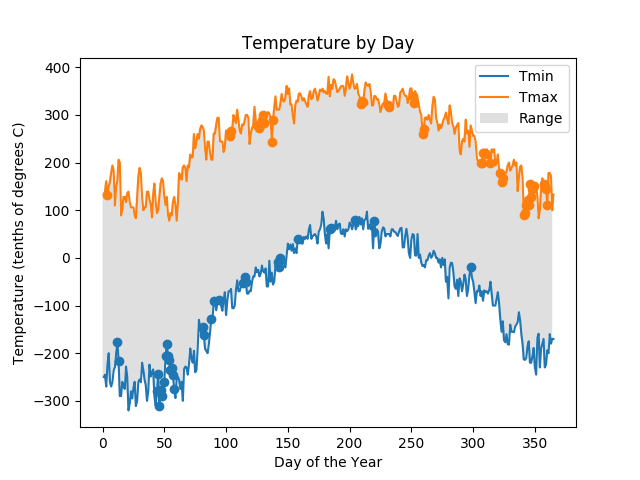

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

title = 'Temperature by Day'
    
y = 'DayOfYear'
X = ['TMIN', 'TMAX']
ylabel = 'Temperature (tenths of degrees C)'
xlabel = 'Day of the Year'
lineTyp = '-'

# line plot
plt.plot(temperature_2015_df[y], temperature_2015_df['TMIN'], lineTyp)  
plt.plot(temperature_2015_df[y], temperature_2015_df['TMAX'], lineTyp)   

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel);

plt.gca().fill_between(range(len(temperature_2015_df['TMIN'])), 
                   temperature_2015_df['TMIN'], temperature_2015_df['TMAX'], 
                   facecolor='grey', 
                   alpha=0.25)

# add a legend with legend entries (because we didn't have labels when we plotted the data series)
plt.legend(['Tmin', 'Tmax', 'Range'])

# scatter plot
plt.scatter(temperature_2015_lowRecords[y],temperature_2015_lowRecords['TMIN'])
plt.scatter(temperature_2015_highRecords[y],temperature_2015_highRecords['TMAX'])

plt.show()

## Clean line plot
based on minimum chart junk principle

### Final version

<IPython.core.display.Javascript object>


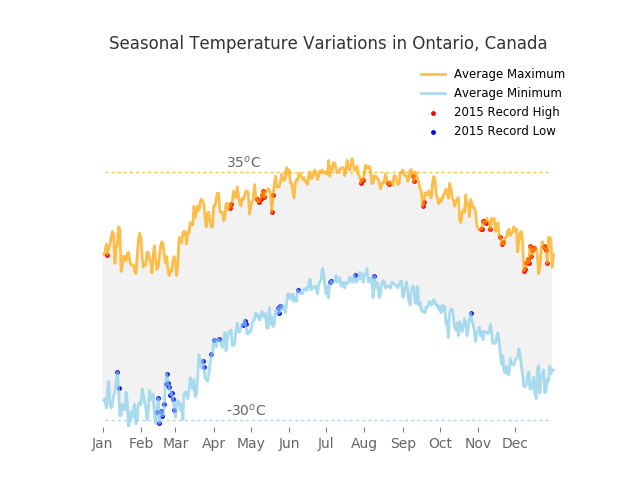

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

title = 'Temperature by Day'
    
y = 'DayOfYear'
X = ['TMIN', 'TMAX']
ylabel = 'Temperature (tenths of degrees C)'
xlabel = 'Day of the Year'
lineTyp = '-' # ':', '-.', '--', '-'
# https://matplotlib.org/examples/lines_bars_and_markers/line_styles_reference.html

# scatter plot
plt.scatter(temperature_2015_highRecords[y],temperature_2015_highRecords['TMAX'], s=6, c='red')
plt.scatter(temperature_2015_lowRecords[y],temperature_2015_lowRecords['TMIN'], s=6, c='blue')

# line plot
plt.plot(temperature_2015_df[y], temperature_2015_df['TMAX'], lineTyp, color='orange', linewidth=2, alpha=0.7)
plt.plot(temperature_2015_df[y], temperature_2015_df['TMIN'], lineTyp, color='skyblue', linewidth=2, alpha=0.7)  

# add a legend with legend entries (because we didn't have labels when we plotted the data series)
# https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.legend
plt.legend(['Average Maximum', 'Average Minimum', '2015 Record High', '2015 Record Low'], loc=1, frameon=False, fontsize=8.5)

plt.gca().fill_between(range(len(temperature_2015_df['TMIN'])), 
                   temperature_2015_df['TMIN'], temperature_2015_df['TMAX'], 
                   facecolor='grey', 
                   alpha=0.1)

plt.ylim(ymin=-320,ymax=650)
plt.axhline(y=350,xmin=0.05,xmax=0.95,color='orange',linewidth=1,alpha=0.7,lineStyle=':')#,label='35C'
plt.text(100,360,'$35^o$C',rotation=0,alpha=0.6)#'grey')
plt.axhline(y=-300,xmin=0.05,xmax=0.95,color='skyblue',linewidth=1,alpha=0.7,lineStyle=':')
plt.text(100,-290,'-$30^o$C',rotation=0,alpha=0.6)#'grey') #https://stackoverflow.com/questions/13413112/creating-labels-where-line-appears-in-matplotlib-figure

# clean things up
## customized manual labelling for each month
pos = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) # 12 months #np.arange(len(temperature_2015_df['DayOfYear']))
month = np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #temperature_2015_df['MonthDay']
# soften all labels by turning grey
plt.xticks(pos, month, alpha=0.6)
# remove the Y label since bars are directly labeled
#plt.ylabel(ylabel, alpha=0.6)
plt.title('Seasonal Temperature Variations in Ontario, Canada', alpha=0.8)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top='off', bottom='on', left='off', right='off', labelleft='off', labelbottom='on', color='grey')

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()

### Old Version with no X-axis

<IPython.core.display.Javascript object>


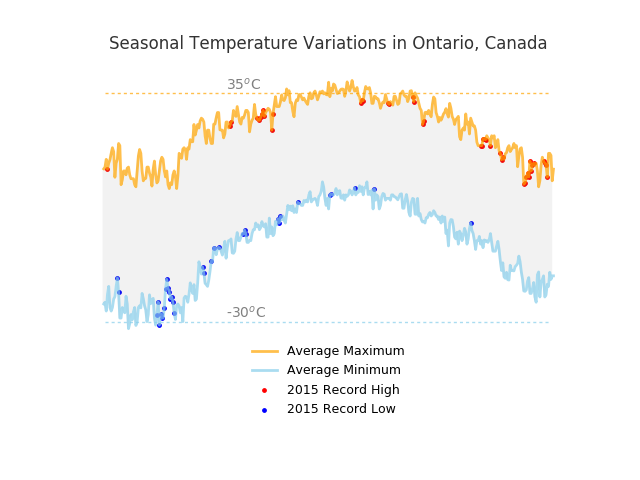

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

title = 'Temperature by Day'
    
y = 'DayOfYear'
X = ['TMIN', 'TMAX']
ylabel = 'Temperature (tenths of degrees C)'
xlabel = 'Day of the Year'
lineTyp = '-' # ':', '-.', '--', '-'
# https://matplotlib.org/examples/lines_bars_and_markers/line_styles_reference.html

# scatter plot
plt.scatter(temperature_2015_highRecords[y],temperature_2015_highRecords['TMAX'], s=6, c='red')
plt.scatter(temperature_2015_lowRecords[y],temperature_2015_lowRecords['TMIN'], s=6, c='blue')

# line plot
plt.plot(temperature_2015_df[y], temperature_2015_df['TMAX'], lineTyp, color='orange', linewidth=2, alpha=0.7)
plt.plot(temperature_2015_df[y], temperature_2015_df['TMIN'], lineTyp, color='skyblue', linewidth=2, alpha=0.7)  

# add a legend with legend entries (because we didn't have labels when we plotted the data series)
# https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.legend
plt.legend(['Average Maximum', 'Average Minimum', '2015 Record High', '2015 Record Low'], loc=8, frameon=False, prop={'size': 9})

plt.gca().fill_between(range(len(temperature_2015_df['TMIN'])), 
                   temperature_2015_df['TMIN'], temperature_2015_df['TMAX'], 
                   facecolor='grey', 
                   alpha=0.1)

plt.ylim(ymin=-600,ymax=450)
plt.axhline(y=350,xmin=0.05,xmax=0.95,color='orange',linewidth=1,alpha=0.7,lineStyle=':')#,label='35C'
plt.text(100,360,'$35^o$C',rotation=0,color='grey')
plt.axhline(y=-300,xmin=0.05,xmax=0.95,color='skyblue',linewidth=1,alpha=0.7,lineStyle=':')
plt.text(100,-290,'-$30^o$C',rotation=0,color='grey') #https://stackoverflow.com/questions/13413112/creating-labels-where-line-appears-in-matplotlib-figure

plt.title('Seasonal Temperature Variations in Ontario, Canada', alpha=0.8)

# clean things up

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()